<a href="https://colab.research.google.com/github/spe301/Wikipedia-Capstone/blob/app/Discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

Wikipedia, as the name implies, is the Encyclopedia of the 21st century! It is an amazing place full of free information mantained by a community of volenteer editors. It has assisted in the removal of barriers when it comes to giving and receiving knwoledge. Unfortunatley, with this great democritization comes the potential spread of misinformation and plagarized content. With the rise of complex transformer models such as GPT2, AI can generate persuasive content that is practically identical to human written text.
See what I mean!: https://techcrunch.com/2019/02/17/openai-text-generator-dangerous/

This is where machine learning can help! We can train a Machine learning model to classify whether or not a body of text has been written by a human or an AI and use other NLP strategies to catch plagarism. If this seems like a problem you care about then keep reading!

* Spencer Holley
* aacjpw@gmail.com
* https://github.com/spe301/Wikipedia-Capstone

## Use cases

* wikipedia users and contributers can flag AI generated articles
* prevent AI generated fake news from spreading
* teachers and professors can flag AI generated essays 

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models, layers
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from matplotlib import pyplot as plt
from math import log
from keras.regularizers import  L2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import  KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from xgboost import XGBClassifier, XGBRegressor
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import  confusion_matrix
import seaborn as sns

class MachineLearning:
    
    def CompareModels(self, data, target, task):
        '''compares out the box accuracy for sklearn models'''
        X = data.drop([target], axis='columns')
        y = data[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        n = len(np.unique(y))
        if task == 'Classification':
            if n == 2:
                methods = [KNeighborsClassifier(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(),
                           AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), LogisticRegression(),
                           SVC()]
                strs = ['KNN', 'NB', 'DT', 'RF', 'AB', 'GB', 'XGB', 'Log', 'SVM']
            else:
                methods = [KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(),
                           AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), SVC()]
                strs = ['KNN', 'DT', 'RF', 'AB', 'GB', 'XGB', 'SVM']
        if task == 'Regression':
            methods = [LinearRegression(), KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(),
                       AdaBoostRegressor(), GradientBoostingRegressor(), XGBRegressor(), SVR()]
            strs = ['Lin', 'KNN', 'DT', 'RF', 'AB', 'GB', 'XGB', 'SVM']
        train_acc = []
        test_acc = []
        for i in range(len(methods)):
            model = methods[i].fit(X_train, y_train)
            train_acc.append(model.score(X_train, y_train))
            test_acc.append(model.score(X_test, y_test))
            c1 = pd.DataFrame(strs)
            c2 = pd.DataFrame(train_acc)
            c3 = pd.DataFrame(test_acc)
            results = pd.concat([c1, c2, c3], axis='columns')
            results.columns = ['Model', 'train_acc', 'test_acc']
        return results
    
    def Optimize(self, model, parameters, data, target, metric='accuracy'):
        '''runs a gridsearch on a given sklearn model'''
        X = data.drop([target], axis='columns')
        y = data[target]
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
            return GridSearchCV(model, parameters, cv=5, scoring=metric, n_jobs=-1, verbose=2).fit(X_train, y_train).best_estimator_
        except:
            return GridSearchCV(model, parameters, cv=5, n_jobs=-1, verbose=2).fit(X_train, y_train).best_estimator_
        
    @classmethod    
    def StackIt(self, cls, model, parameters, data, target, task, ensemble=False):
        '''does the same thing as optimize, however it also returns a visulaization that represents the model's preformance'''
        dh = DataHelper()
        ev = Evaluater()
        X = dh.HoldOut(data)[0].drop([target], axis='columns')
        Xval = dh.HoldOut(data)[1].drop([target], axis='columns')
        y = dh.HoldOut(data)[0][target]
        yval = dh.HoldOut(data)[1][target]
        mod = cls.Optimize(model, parameters, X, y)
        score = ev.ScoreModel(mod, X, y)
        if task == 'Regression':
            results = ev.EvaluateRegressor(mod, X, Xval, y, yval)
            return mod, score, results
        if task == 'Classification':
            fit = mod.fit(X, y)
            cm = ev.BuildConfusion(fit, Xval, yval)
            if ensemble == True:
                importance = ev.GetImportance(mod, X, y)
            else:
                importance = None
        return mod, score, fit, cm, importance
    
    def ClusterIt(self, data, clusters, labeled=False):
        '''uses KMeans algorithm to cluster datapoints'''
        k = KMeans(n_clusters=clusters).fit(data)
        pred = k.predict(data)
        centers = k.cluster_centers_
        X2 = pd.DataFrame(data)
        y = pd.DataFrame(pred)
        y.columns = ['cluster']
        results = pd.concat([X2, y], axis='columns')
        plt.scatter(data[:, 0], data[:, 1], s=10, c=pred);
        plt.scatter(centers[:, 0], centers[:, 1], s=70, c='black');
        plt.show()
        return results
    
    def DeepTabular(self, task, data, target, params):
        '''trains a Feed-Forward Neural Network on tabular data '''
        dh = DataHelper()
        X = np.array(dh.HoldOut(data)[0].drop([target], axis='columns'))
        Xval = np.array(dh.HoldOut(data)[1].drop([target], axis='columns'))
        y = dh.HoldOut(data)[0][target]
        yval = dh.HoldOut(data)[1][target]
        base = params['base']
        activation = params['activation']
        loss = params['loss']
        optimizer = params['optimizer']
        batch_size = params['batch_size']
        epochs = params['epochs']
        if task == 'Regression':
            output_dim = 1
            oa = 'linear'
        if task == 'Classification':
            output_dim = len(np.unique(y))
            if output_dim == 2:
                oa = 'sigmoid'
            else:
                oa = 'softmax'
        model = keras.models.Sequential()
        model.add(keras.layers.Dense(base, activation=activation))
        model.add(keras.layers.Dense(int(base/2), activation=activation))
        model.add(keras.layers.Dense(int(base/4), activation=activation))
        model.add(keras.layers.Dense(output_dim, activation=oa))
        model.compile(loss=loss, optimizer=optimizer)
        model.fit(X, y, batch_size=batch_size, epochs=epochs)
        model.evaluate(Xval, yval)
        return model
   
class Evaluater:
    
    def ScoreModel(self, model, X, y):
        '''scores a sklearn model'''
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        algo = model.fit(X_train, y_train)
        return 'Training: {}, Validation: {}'.format(algo.score(X_train, y_train), algo.score(X_test, y_test))
    
    def BuildConfusion(self, fitted_model,  Xval, yval, cmap='plasma', normalize="true"):
        '''spits out a confusion matrix'''
        cm = plot_confusion_matrix(fitted_model, Xval, yval, cmap=cmap, normalize=normalize)
        return cm

    def BuildTree(self, tree):
        '''visulization for decision trees'''
        try:
            return plot_tree(tree)
        except:
            return 'Please pass a tree class'
    
    def GetCoefficients(self, model, X, y):
      '''returns a model's coefficients'''
      try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        model.fit(X_train, y_train)
        return 'coefficients: {}'.format(model.coef_)
      except:
        return 'Please pass LinearRegression, LogisticRegression, or an SVM with a linear kernel'
        
    def GetImportance(self, model, X, y):
      '''returns a feature importance graph given a model and dataset'''
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
      model.fit(X_train, y_train)
      try:
        FI = model.feature_importances_
        n_features = X_train.shape[1]
        plt.figure(figsize=(8,8))
        plt.barh(range(n_features), FI, align='center') 
        plt.yticks(np.arange(n_features), X_train.columns.values) 
        plt.xlabel('Feature importance')
        plt.ylabel('Feature')
      except:
          return 'Please pass an ensemble class'
        
    def AUC(self, model, Xval, yval):
      '''displays AUC to evaluate a classification model'''
      pred = model.predict(Xval)
      fpr, tpr, threshold = roc_curve(yval, pred)
      return auc(fpr, tpr)

    def BuildConfusionDL(self, model, X, y, normalize='true', cmap='plasma'):
      '''displays a confusion matrix to evaluate a deep learning classifier'''
      yhat = []
      yreal = y.argmax(axis=1)
      pred = model.predict(X)
      prediction = pred.argmax(axis=1)
      cm = confusion_matrix(yreal, prediction, normalize=normalize)
      plot = sns.heatmap(cm, annot=True, cmap=cmap);
      plot.set_ylabel('True')
      plot.set_xlabel('Predict')
      return plot

class DataHelper:

    def ScaleData(self, strategy, y_var, data):
        '''scales tabular data'''
        X = data.drop([y_var], axis='columns')
        if strategy == 'minmax':
            return MinMaxScaler().fit(X).transform(X)
        if strategy == 'standard':
            return StandardScaler().fit(X).transform(X)
        if strategy == 'mean':
            for col in X.columns:
                X[col] = (X[col] - min(X[col]))/ (max(X[col]) - min(X[col]))
            return X
        
    def HoldOut(self, data):
        '''seperates out 10% of a dataset as unseen testing data'''
        train, test = train_test_split(data, test_size=0.1)
        return train, test
    
    def MakeNewDF(self, X, y, k):
      '''removes all features that aren't of k best'''
      selector = SelectKBest(k=k).fit(X, y)
      mask = selector.get_support()
      selected = []
      for i in range(len(mask)):
        if mask[i] == True:
          selected.append(X.columns[i])
      df = pd.DataFrame(selector.transform(X))
      df.columns = selected
      return df
    
    def VifIt(self, X):
      '''calculates the VIF score of each feature in a dataset'''
      vif = pd.Series([variance_inflation_factor(X.values, i) 
        for i in range(X.shape[1])], index=X.columns)
      return vif

    def MulticlassOutput(self, df, col):
      '''output preprocessing'''
      enc = OneHotEncoder()
      y = np.array(df[col]).reshape(-1, 1)
      oh = enc.fit_transform(y).toarray()
      return oh


    def ModelReadyText1(self, df, Xcol, ycol, pad):
      '''converts text into tokenized sequences'''
      text = list(df[Xcol])
      t = Tokenizer()
      t.fit_on_texts(text)
      tokens = t.texts_to_sequences(text)
      tokens2 = pad_sequences(tokens, maxlen=pad)
      dh = DataHelper()
      y = dh.MulticlassOutput(df, ycol)
      return tokens2, y

    def ModelReadyString(self, text_str, pad):
      '''converts an individual unit of text into tokenized sequences'''
      text = [text_str]
      t = Tokenizer()
      t.fit_on_texts(text)
      tokens = t.texts_to_sequences(text)
      tokens2 = pad_sequences(tokens, maxlen=pad)
      return tokens2

    def ModelReadyText2(self, df, Xcol, ycol, num_words):
      '''converts text into one-hot-encoded vectors'''
      dh = DataHelper()
      text = list(df[Xcol])
      t = Tokenizer(num_words=num_words)
      t.fit_on_texts(text)
      oh = t.texts_to_matrix(text)
      y = dh.MulticlassOutput(df, ycol)
      return oh, y

    def ViewAccuracy(self, history, epochs):
      '''plots a model's accuracy throughout training'''
      plt.plot(range(epochs), history.history['accuracy'], label='train');
      plt.plot(range(epochs), history.history['val_accuracy'], label='val');
      plt.legend(loc='best')
      plt.xlabel('epochs')
      plt.ylabel('accuracy')
      return None


    def ViewLoss(self, history, epochs):
      '''plots a model's loss throughout training'''
      plt.plot(range(epochs), history.history['loss'], label='train');
      plt.plot(range(epochs), history.history['val_loss'], label='val');
      plt.legend(loc='best')
      plt.xlabel('epochs')
      plt.ylabel('loss')
      return None

class DeepLearning:

  def Powers(self, n):
    '''help the model building functions determine nlayers'''
    k = int(log(n, 2))
    return k

  def Sparsity(self, x):
    '''help the model building function know when to use 'sparse_categorical_crossentropy' as loss function'''
    df = pd.DataFrame(x[0])
    df.columns = ['val']
    df2 = df.loc[df['val'] == 0]
    return len(df)*0.9 <= len(df2)

  def FeedForward(self, nodes, activation, optimizer, dropout, regularizer, inp, nclasses):
    '''builds a simple neural net with only Dense Layers'''
    dl = DeepLearning()
    if nclasses > 16:
      pen = nclasses*2
    else:
      pen = 16
    if nclasses == 2:
      oa = 'sigmoid'
      loss = 'binary_crossentropy'
    else:
      oa = 'softmax'
      if dl.Sparsity(X) == False:
        loss = 'categorical_crossentropy'
      else:
        loss = 'sparse_categorical_crossentropy'
    model = models.Sequential()
    if regularizer == None:
      model.add(layers.Dense(nodes, activation=activation, input_shape=(inp,)))
    if regularizer == 'L1':
      model.add(layers.Dense(nodes, activation=activation, input_shape=(inp,), kernel_regularizer=l1(0.005)))
    if regularizer == 'L2':
      model.add(layers.Dense(nodes, activation=activation, input_shape=(inp,), kernel_regularizer=L2(0.005)))
    if dropout == True:
      model.add(layers.Dropout(0.5))
    p = dl.Powers(nodes)
    for i in range(p):
      nodes /= 2
      nodes = int(nodes)
      if nodes > 16:
        if nodes > nclasses:
          model.add(layers.Dense(nodes, activation=activation))
    model.add(layers.Dense(pen, activation=activation))
    model.add(layers.Dense(nclasses, activation=oa))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

  def RNN(self, nodes, activation, optimizer, dropout, regularizer, method, stacking, inp, nclasses):
    '''builds a neural network with LSTM or GRU layer(s)'''
    dl = DeepLearning()
    if nclasses > 16:
      pen = nclasses*2
    else:
      pen = 16
    if nclasses == 2:
      oa = 'sigmoid'
      loss = 'binary_crossentropy'
    else:
      oa = 'softmax'
      if dl.Sparsity(X) == False:
        loss = 'categorical_crossentropy'
      else:
        loss = 'sparse_categorical_crossentropy'  
    model = models.Sequential()
    model.add(layers.Embedding(inp, nodes))
    if method == 'LSTM':
      if regularizer == None:
        model.add(layers.LSTM(nodes, activation=activation, return_sequences=stacking))
      if regularizer == 'L1':
        model.add(layers.LSTM(nodes, activation=activation, kernel_regularizer=l1(0.005), return_sequences=stacking))
      if regularizer == 'L2':
        model.add(layers.LSTM(nodes, activation=activation, kernel_regularizer=L2(0.005), return_sequences=stacking))
    if method == 'GRU':
      if regularizer == None:
        model.add(layers.GRU(nodes, activation=activation, return_sequences=stacking))
      if regularizer == 'L1':
        model.add(layers.GRU(nodes, activation=activation, kernel_regularizer=l1(0.005), return_sequences=stacking))
      if regularizer == 'L2':
        model.add(layers.GRU(nodes, activation=activation, kernel_regularizer=L2(0.005), return_sequences=stacking))
    if dropout == True:
      model.add(layers.Dropout(0.5))
    dl = DeepLearning()
    if stacking == True:
      nodes = nodes//2
      if method == 'LSTM':
        model.add(layers.LSTM(nodes, activation=activation))
      else:
        model.add(layers.GRU(nodes, activation=activation))
    p = dl.Powers(nodes)
    for i in range(p):
      nodes /= 2
      nodes = int(nodes)
      if nodes > 16:
        if nodes > nclasses:
          model.add(layers.Dense(nodes, activation=activation))
    model.add(layers.Dense(pen, activation=activation))
    model.add(layers.Dense(nclasses, activation=oa))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

  def Bidirectional(self, vocab, nodes, output, optimizer, metrics, activation, method):
    '''Bidirectional RNN Building function'''
    if output == 1:
      oa = 'linear'
      loss = 'mse'
    if output == 2:
      oa = 'sigmoid'
      loss = 'binary_crossentropy'
    else:
      oa = 'softmax'
      loss = 'categorical_crossentropy'
    model = models.Sequential()
    model.add(layers.Embedding(vocab, nodes))
    if method == 'LSTM': 
      model.add(layers.Bidirectional(layers.LSTM(nodes))) 
    if method == 'GRU':
      model.add(layers.Bidirectional(layers.GRU(nodes)))
    model.add(layers.Dense(nodes/2, activation=activation))
    model.add(layers.Dense(nodes/4, activation=activation))
    model.add(layers.Dense(output, activation=oa))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

  def TestDL(self, params, func, task, X, y, X_val=None, y_val=None, batch_size=64, epochs=50, cv=3, patience=5):
    task = task.lower()
    '''wraps the keras wrapper functions and GridSearchCV into a simple one liner, one line plus the parameter grid'''
    early_stopping = [EarlyStopping(patience=patience), ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')]
    if task == 'classification':
      k = KerasClassifier(func)
    if task == 'regression':
      k = KerasRegressor(func)
    grid = GridSearchCV(k, params, cv=cv)
    if type(X_val) != np.ndarray:
      grid.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=early_stopping)
    else:
      grid.fit(X, y, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=early_stopping)
    return grid

dh = DataHelper()
dl = DeepLearning()
ev = Evaluater()
ml = MachineLearning()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Obtain Data

We will concatenate the 180 generated articles with 180 randomly selected real articles

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/spe301/Wikipedia-Capstone/main/Data/HumanText.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis='columns')
df2 = pd.read_csv('drive/MyDrive/Generated.csv').drop(['Unnamed: 0'], axis='columns')
data = pd.concat([df.sample(n=180), df2])
data

,Text,Human,AI
762,"the university of memphis in 1909, the tenness...",1,0
313,"health is a state of physical, mental and soci...",1,0
179,critical theory is an approach to social phil...,1,0
323,"hinduism is an indian religion and dharma, or ...",1,0
168,a corvette is a small warship. it is tradition...,1,0
...,...,...,...
175,by jonathan rosen\n\njonathan rosen is a senio...,0,1
176,he was able to maintain good relations with t...,0,1
177,mealworms are shed during the larval phase of ...,0,1
178,"by\n\nby 2015, syrian president muammar gaddaf...",0,1


## Data Preproccessing 

In [ ]:
avg = 0
for i in range(len(data['Text'])):
  avg += len(list(data['Text'])[i].split(' '))/len(data)

pad = int(avg)
pad

1689

In [ ]:
train, test = dh.HoldOut(data)

In [ ]:
text, lables = dh.ModelReadyText1(train, 'Text', 'AI', pad)
Xtest, ytest = dh.ModelReadyText1(test, 'Text', 'AI', pad)

In [ ]:
import numpy as np

words = []
for i in range(len(train)):
  word_lst = list(train['Text'])[i].replace('\n', ' ').split(' ')
  for word in word_lst:
    words.append(word.replace('.', '').replace(',', '').replace(' ', '').replace('"', '').replace(':', '').replace(';', '').replace('!', ''))

vocab = len(np.unique(words))
vocab

43149

# Modeling

## Bidirectional RNN Gridsearch

In [ ]:
params = {'vocab':[vocab], 'nodes': [128, 64, 32], 'output': [2], 'optimizer': ['adam', 'rmsprop'],
          'metrics': ['accuracy'], 'activation': ['relu', 'tanh'], 'method': ['LSTM', 'GRU']}

grid = dl.TestDL(params, dl.Bidirectional, 'classification', text, lables, batch_size=32)

Epoch 1/50
6/6 [==============================] - 4s 328ms/step - loss: 0.6909 - accuracy: 0.4624 - val_loss: 0.6770 - val_accuracy: 0.7500
Epoch 2/50
6/6 [==============================] - 1s 235ms/step - loss: 0.6621 - accuracy: 0.7702 - val_loss: 0.6261 - val_accuracy: 0.7727
Epoch 3/50
6/6 [==============================] - 1s 208ms/step - loss: 0.5834 - accuracy: 0.7829 - val_loss: 0.4764 - val_accuracy: 0.7727
Epoch 4/50
6/6 [==============================] - 1s 209ms/step - loss: 0.4492 - accuracy: 0.7911 - val_loss: 0.4644 - val_accuracy: 0.7955
Epoch 5/50
6/6 [==============================] - 1s 215ms/step - loss: 0.4601 - accuracy: 0.8036 - val_loss: 0.4478 - val_accuracy: 0.7727
Epoch 6/50
6/6 [==============================] - 1s 217ms/step - loss: 0.4238 - accuracy: 0.8084 - val_loss: 0.4531 - val_accuracy: 0.7727
Epoch 7/50
6/6 [==============================] - 1s 215ms/step - loss: 0.4390 - accuracy: 0.7818 - val_loss: 0.4442 - val_accuracy: 0.7727
Epoch 8/50
6/6 [====

## Evaluation of best model

In [ ]:
grid.best_estimator_.model.save('drive/MyDrive/bid.h5')

In [ ]:
grid.best_params_

{'activation': 'relu',
 'method': 'GRU',
 'metrics': 'accuracy',
 'nodes': 32,
 'optimizer': 'adam',
 'output': 2,
 'vocab': 43284}

In [ ]:
X, y = dh.ModelReadyText1(test, 'Text', 'AI', pad)
grid.best_estimator_.score(X, y)

2/2 [==============================] - 0s 46ms/step - loss: 1.6037 - accuracy: 0.6389


0.6388888955116272

In [ ]:
grid.best_estimator_.score(text, lables)

11/11 [==============================] - 1s 52ms/step - loss: 0.2104 - accuracy: 0.9444


0.9444444179534912

## LSTM and GRU gridsearch

Because doing a fully exaustive gridsearch would be computationally expensive, I played around a little mannually to help gain an intuition of how to narrow down the gridsearch.

In [ ]:
params = {'nodes': [32], 'activation': ['relu', 'tanh'], 'optimizer': ['adam'], 'dropout': [True, False],
          'regularizer': [None, 'L1'], 'method': ['LSTM', 'GRU'], 'stacking': [True, False], 'inp': [vocab],
          'nclasses': [2]}

grid = dl.TestDL(params, dl.RNN, 'classification', text, lables, batch_size=32)

Epoch 1/50
6/6 [==============================] - 40s 6s/step - loss: 0.6934 - accuracy: 0.3778 - val_loss: 0.6937 - val_accuracy: 0.3864
Epoch 2/50
6/6 [==============================] - 38s 6s/step - loss: 0.6928 - accuracy: 0.5438 - val_loss: 0.6940 - val_accuracy: 0.3864
Epoch 3/50
6/6 [==============================] - 38s 6s/step - loss: 0.6927 - accuracy: 0.5046 - val_loss: 0.6939 - val_accuracy: 0.4318
Epoch 4/50
6/6 [==============================] - 38s 6s/step - loss: 0.6916 - accuracy: 0.5803 - val_loss: 0.6944 - val_accuracy: 0.4318
Epoch 5/50
6/6 [==============================] - 38s 6s/step - loss: 0.6899 - accuracy: 0.6014 - val_loss: 0.6934 - val_accuracy: 0.4545
Epoch 6/50
6/6 [==============================] - 38s 6s/step - loss: 0.6889 - accuracy: 0.5770 - val_loss: 0.6910 - val_accuracy: 0.4773
Epoch 7/50
6/6 [==============================] - 38s 6s/step - loss: 0.6834 - accuracy: 0.7985 - val_loss: 0.6767 - val_accuracy: 0.7500
Epoch 8/50
6/6 [==================

In [ ]:
grid.best_estimator_.model.save('drive/MyDrive/rnn.h5')

In [ ]:
grid.best_params_

{'activation': 'tanh',
 'dropout': False,
 'inp': 41994,
 'method': 'GRU',
 'nclasses': 2,
 'nodes': 32,
 'optimizer': 'adam',
 'regularizer': 'L1',
 'stacking': False}

In [ ]:
X, y = dh.ModelReadyText1(test, 'Text', 'AI', pad)
grid.best_estimator_.score(X, y)

2/2 [==============================] - 0s 24ms/step - loss: 2.1730 - accuracy: 0.4444


0.4444444477558136

In [ ]:
grid.best_estimator_.score(text, lables)

11/11 [==============================] - 0s 25ms/step - loss: 0.2945 - accuracy: 0.9444


0.9444444179534912

## Using the best models

In [ ]:
model = models.load_model('drive/MyDrive/bid.h5')

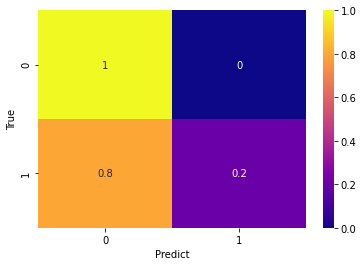

In [ ]:
#model.predict(Xtest)
ev.BuildConfusionDL(model, Xtest, ytest)

In [ ]:
model2 = models.load_model('drive/MyDrive/rnn.h5')

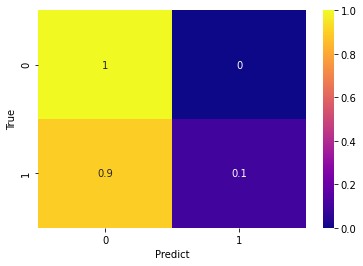

In [ ]:
ev.BuildConfusionDL(model2, Xtest, ytest)

## Going further with the non-bidirectional model

I am going with this one because there was a better TPR (True Positive Rate).

In [ ]:
test.reset_index(inplace=True)

In [ ]:
sample = test.iloc[np.random.randint(35)]
truth = sample['AI']
text_str = sample['Text']
text_str

' is part of the cranium. the cranium is the outer layer of the skull, the largest and most complex of the three mammalian skulls. it contains many sutures, embedded nerves, sinuses, and foramen. it is also where the air and water of the lungs are vented. cranium is divided into three parts, a lower jaw, an upper jaw and a gill pouch.the fossil skull of a 17- to 18-million-year-old homin was discovered in the jakarta desert in september 2006 by thomas henry trompfert. its skull measures 15.2 by 10.1 by 3.6 metres  the knuckle-less, or "phulpen knuckle", is a hominid of the middle Pleistocene species and thus closely related to modern humans.the hominid cranium is a classic example of a "supercranial" skull. the skull, which measures 15.3 by 11.1 by 3.5 metres  a 2016 study of the skull of a hominid from china identified a partial occiputectomy, possibly a type of retrocranial sutura. the retrocranial sutura is a partial occiputectomy of the frontal part of the skull.the earliest known 

In [ ]:
to_pred = dh.ModelReadyString(text_str, pad)
output = model2.predict(to_pred)
print('We predict a {}% probability that an AI wrote this.'.format(round(output[0][1]*100, 2)))

We predict a 99.55% probability that an AI wrote this.


In [ ]:
sample

level_0                                                    5
index                                                    136
Text        is part of the cranium. the cranium is the ou...
Human                                                      0
AI                                                         1
Name: 5, dtype: object

## Last attempt at model building

With 50 epochs per model, many Bidirectional models reached a point of diminishing returns with the better ones mostly peaking at around 20 epochs.

In [ ]:
params = {'vocab':[vocab], 'nodes': [128, 64, 32], 'output': [2], 'optimizer': ['adam', 'rmsprop'],
          'metrics': ['accuracy'], 'activation': ['relu', 'tanh'], 'method': ['LSTM', 'GRU']}

grid = dl.TestDL(params, dl.Bidirectional, 'classification', text, lables, batch_size=32, epochs=19)

Epoch 1/19
6/6 [==============================] - 5s 392ms/step - loss: 0.6894 - accuracy: 0.5280 - val_loss: 0.6825 - val_accuracy: 0.6818
Epoch 2/19
6/6 [==============================] - 1s 228ms/step - loss: 0.6500 - accuracy: 0.7961 - val_loss: 0.6607 - val_accuracy: 0.7955
Epoch 3/19
6/6 [==============================] - 1s 224ms/step - loss: 0.5789 - accuracy: 0.7917 - val_loss: 0.4838 - val_accuracy: 0.7955
Epoch 4/19
6/6 [==============================] - 1s 226ms/step - loss: 0.4400 - accuracy: 0.8074 - val_loss: 0.3488 - val_accuracy: 0.8636
Epoch 5/19
6/6 [==============================] - 1s 229ms/step - loss: 0.8266 - accuracy: 0.5810 - val_loss: 0.3899 - val_accuracy: 0.8409
Epoch 6/19
6/6 [==============================] - 1s 229ms/step - loss: 0.4722 - accuracy: 0.7916 - val_loss: 0.4152 - val_accuracy: 0.7955
Epoch 7/19
6/6 [==============================] - 1s 225ms/step - loss: 0.4776 - accuracy: 0.7668 - val_loss: 0.4162 - val_accuracy: 0.7955
Epoch 8/19
6/6 [====

In [ ]:
grid.best_params_

{'activation': 'tanh',
 'method': 'LSTM',
 'metrics': 'accuracy',
 'nodes': 64,
 'optimizer': 'rmsprop',
 'output': 2,
 'vocab': 45931}

In [ ]:
X, y = dh.ModelReadyText1(test, 'Text', 'AI', pad)
grid.best_estimator_.score(X, y)

2/2 [==============================] - 1s 53ms/step - loss: 0.3815 - accuracy: 0.8333


0.8333333134651184

In [ ]:
grid.best_estimator_.score(text, lables)

11/11 [==============================] - 1s 54ms/step - loss: 0.0941 - accuracy: 0.9691


0.9691358208656311

In [ ]:
grid.best_estimator_.model.save('drive/MyDrive/BidFinal.h5')

In [ ]:
model3 = models.load_model('drive/MyDrive/BidFinal.h5')

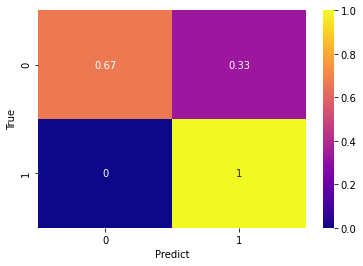

In [ ]:
ev.BuildConfusionDL(model3, Xtest, ytest)

Testing the model on a random article

In [ ]:
sample = test.iloc[np.random.randint(35)]
truth = sample['AI']
text_str = sample['Text']
to_pred = dh.ModelReadyString(text_str, pad)
output = model3.predict(to_pred)
print('We predict a {}% probability that an AI wrote this.'.format(round(output[0][1]*100, 2)))

We predict a 46.13% probability that an AI wrote this.


In [ ]:
sample

Text     oral sex, sometimes referred to as oral interc...
Human                                                    1
AI                                                       0
Name: 513, dtype: object

## Text EDA

1. What would a wordcloud look like for these two seperate collections of text?

insight: first was a major word for both the AI written and Human written articles because the articles often mention that the topic was or is the first to do or be something in particular. United States and german were major in the AI written text because there were many political articles whereas the real articles used terms more general words, like may and many, because they were over a wider variety of topics

In [9]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

AI = ','.join(data.loc[data['AI']==1]['Text'])
Human = ','.join(df['Text'])

In [19]:
AiCloud = WordCloud(max_words=50, stopwords=STOPWORDS, background_color='white').generate(AI)
HumanCloud = WordCloud(max_words=50, stopwords=STOPWORDS, background_color='white').generate(Human)

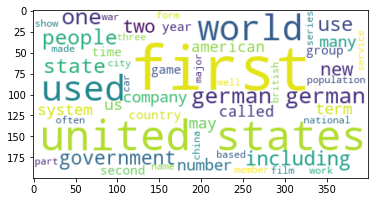

In [20]:
plt.imshow(AiCloud, interpolation='bilinear')

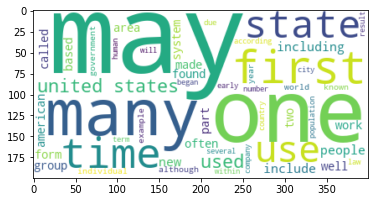

In [21]:
plt.imshow(HumanCloud, interpolation='bilinear')

2. What percentage of AI generated text is stopwords compared to the human written text?

insight: both have very little stopwords but the real articles have a slightly lower use of stopwords at 0.39% compared to 0.44%

In [25]:
AiWords = AI.split(' ')
HumanWords = Human.split(' ')
AiStoppers = 0
for word in AiWords:
  if word in list(STOPWORDS):
    AiStoppers += 1

HumanStoppers = 0
for word in HumanWords:
  if word in list(STOPWORDS):
    HumanStoppers += 1

print('the AI written text is {}% stopwords and the Human written text is {}% stopwords'.format(round(AiStoppers/len(AiWords), 2), round(HumanStoppers/len(HumanWords), 2)))

the AI written text is 0.44% stopwords and the Human written text is 0.39% stopwords
